In [145]:
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
cd workspace/theislab/mubind/notebooks/batch

[Errno 2] No such file or directory: 'workspace/theislab/mubind/notebooks/batch'
/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/batch


In [147]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import numpy as np

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [192]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()

df.index = df['seq']
del df['seq']
df.index = df.index.astype(str).str[45:]

df = df[~df.index.duplicated(keep='first')]

n_sample = 10000
data = df.sample(min(df.shape[0], n_sample))

# data = mb.pp.sample_rounds(df, 2, 10000)

# remove as many nucleotides as posisble (faster training/convergence)


# data.index = data.index.astype(str).str[-15:]


In [193]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [194]:
# TODO: skipped for now
n_rounds = 2

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=625,
                         shuffle=False)

loading object (# entries) 10000


In [195]:
import warnings
warnings.filterwarnings('ignore')

In [196]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [197]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [198]:
pd.set_option('display.expand_frame_repr', False)


In [199]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 25
log_each = 10
n_kernels = 4
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)

opt_kernel_shift = [0, 0, 1, 1]
opt_kernel_length = [0, 0, 1, 1]
use_mono = True
use_dinuc = False
dinuc_mode = 'local'

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2, 20, 20],
                                       use_dinuc=use_dinuc, dinuc_mode=dinuc_mode).cuda()
model_by_k, res_next = model.optimize_iterative(train, show_logo=0,
                                                opt_kernel_length=[0, 0, 1, 1], opt_kernel_shift=[0, 0, 1, 1],
                                                dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                # lr=lr, weight_decay=wd, ignore_kernel=ignore_kernel,
                                                num_epochs=n_epochs, early_stopping=early_stopping, # optimiser=torch.optim.LBFGS,
                                                log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
print('##DONE....\n\n')



print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k



here... 2
Using device: cuda:0
current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)


kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 25 
early_stopping: 5
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.966761,  best epoch: 9,  secs per epoch: 0.251 s,  secs epoch*1k trials: 0.025s
Epoch: 21, Loss: 0.842994,  best epoch: 19,  secs per epoch: 0.227 s,  secs epoch*1k trials: 0.023s
Final loss: 0.8426773399
Total time (model/function): (5.192s / 5.192s)
Time per epoch (model/function): (0.216s/ 0.216s)
Time per epoch per 1k trials: 0.022s
Current time: 2023-01-20 11:38:22.332003
optimization of dinuc is not necessary for the intercepts (kernel=0). Skip...
current kernels

Kernel to optim

In [200]:
model = model_by_k
mb.tl.scores(model, train, by='batch')


{0: {'r2_counts': 0.09868875992177173,
  'r2_foldchange': 0.05144373159399296,
  'r2_enr': -0.013826773982056118,
  'r2_fc': 0.0538936880467127,
  'pearson_foldchange': 0.23215014117314833}}

In [201]:
rcParams['figure.figsize'] = 6, 6


In [202]:
counts = mb.tl.predict(model, train)
counts

,t0,t1,p0,p1,batch,n_rounds,enr_pred,enr_obs,f_pred,f_obs
CTTAAGGACTTGCGGGGCTTTACTG,1.0,0.0,0.628587,0.371413,0,2,0.842087,0.5,-0.074643,-0.30103
GCTCCATTTTCGACCTGCAAGCGGG,0.0,1.0,0.551502,0.448498,0,2,0.933610,2.0,-0.029835,0.30103
AGAGGTCAACTTTTAGGTCCACAGA,1.0,0.0,0.581876,0.418124,0,2,0.896483,0.5,-0.047458,-0.30103
CTTATTTGATGGCGACATGAGGGGG,1.0,0.0,0.408963,0.591037,0,2,1.129226,0.5,0.052781,-0.30103
CGACACCCGCCCGCGGAGTCGGGTA,0.0,1.0,0.458569,0.541431,0,2,1.056811,2.0,0.023997,0.30103
...,...,...,...,...,...,...,...,...,...,...
GGCCGCGTTTAACACATGGGGAGGT,1.0,0.0,0.552550,0.447450,0,2,0.932304,0.5,-0.030442,-0.30103
TGTTTATCTCGCGCGTTAACCTTCG,1.0,0.0,0.643310,0.356689,0,2,0.825583,0.5,-0.083239,-0.30103
TCAGAGCTCTGACCATGTGCAGACT,1.0,0.0,0.654537,0.345463,0,2,0.813196,0.5,-0.089805,-0.30103
CTACGATTTTTTTGTTTCACGGGTC,1.0,0.0,0.681621,0.318379,0,2,0.783993,0.5,-0.105688,-0.30103


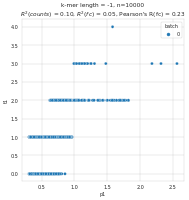

{'r2_counts': 0.09868875992177173,
 'r2_foldchange': 0.05144373159399296,
 'r2_enr': -0.013826773982056118,
 'r2_fc': 0.0538936880467127,
 'pearson_foldchange': 0.23215014117314833}

In [203]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 35

mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')


True
4
(4, 4)
(76, 76)
(76, 76)


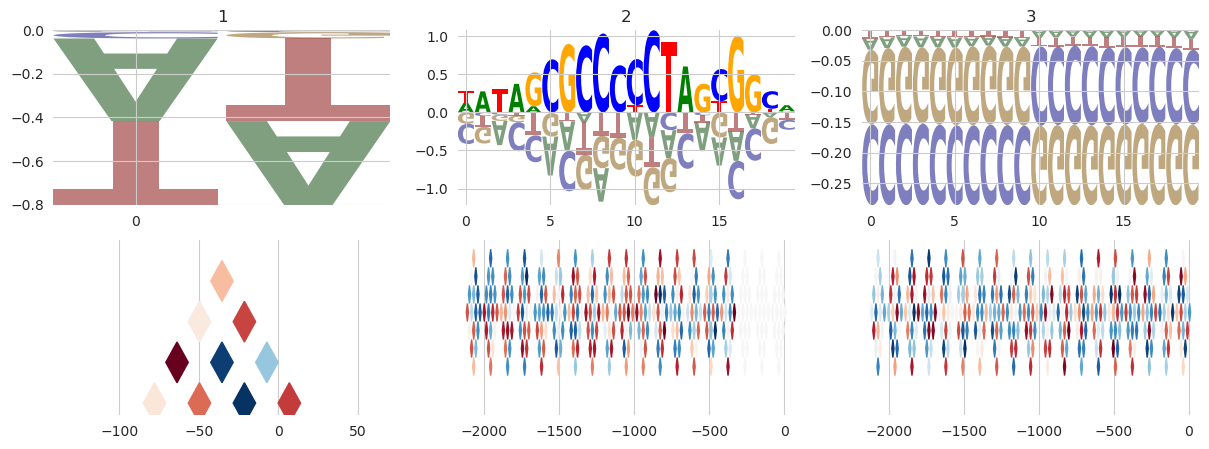

In [204]:
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2)


In [205]:

model = model_by_k
mb.tl.scores(model, train)


{'r2_counts': 0.09868875992177173,
 'r2_foldchange': 0.05144373159399296,
 'r2_enr': -0.013826773982056118,
 'r2_fc': 0.0538936880467127,
 'pearson_foldchange': 0.23215014117314833}

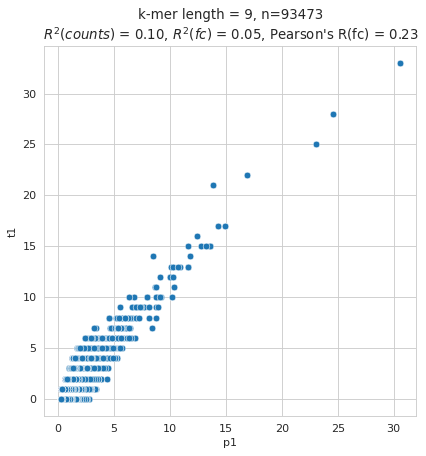

{'r2_counts': 0.09868875992177173,
 'r2_foldchange': 0.05144373159399296,
 'r2_enr': -0.013826773982056118,
 'r2_fc': 0.0538936880467127,
 'pearson_foldchange': 0.23215014117314833}

In [206]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 80

mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=9)
